# Week 2

In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import sys
sys.path.append("../")
import edhec_risk_kit as erk

In [19]:
# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-dark")

**Modern Portfolio Theory (MPT)** was born with the efficient frontier analysis of **Markowitz** (1952). Unfortunately, early applications of the technique, based on naive estimates of the input parameters, have been found to be of little use because they often lead to non-sensible portfolio allocations.

We talked about the MPT a lot in the **notebook of week-2 of the first course**. We constructed the efficient frontiers using past data, and we could see what was the optimal weight allocation when constructing a portfolio of $N$ stocks. 

Of course, such optimal allocation was based on **past** returns and covariances (and variances). However, if we are going to build the portfolio now, we do not know a priori what the efficient frontier looks like just because 
**we do not have future returns and covariances**. **These parameters have to be estimated!**

Here, we focus on bridging the gap between portfolio theory and portfolio construction by showing **how to generate enhanced parameter estimates** so as to improve the quality of the portfolio optimization outputs (optimal portfolio weights), with a focus on risk parameter estimates. We address sample risk and explain **how to improve covariance matrix estimation** via the use of factor and/or Bayesian techniques and statistical shrinkage estimators.

### Curse of dimensionality

Suppose we want to build a portfolio of $N$ stocks (of which we have available data). 
We then should **estimate**: 
- $N$ returns (expected returns), 
- $N$ volatilities, and 
- $N(N-1)/2$ covariances (correlation coefficients), as the covariance matrix contains $N$ entries, from which we remove the diagonal consisting of $N$ variances, and then, since it is symmetric, we divide by the remaining total number of entries). 

As $N$ grows, it may be a problem to have such a large number of parameters to estimate. For example, suppose we want to build a portfolio of $N=500$ stocks (as in the **S&P500**), then we have $N + N(N-1)/2 = N(N+1)/2 = 125,250$ entries to be estimated in the covariance matrix. 

In the presence of large portfolios, **the number of parameters if often larger than the sample size**, i.e., 
the length of the timeseries we have (daily, weekly, monthly). 
In order to get accurate estimates of the parameters we could in principle increase the sample size. 
However, **longer time series may increase modeling bias** and that is why the available sample size is usually in the order of hundreds or a few thousands. Hence, we rather have to end up with reducing the number of parameters.

### Parameter estimations

Recall that, given $N$ assets, we denote by $\Sigma$ be the $N\times N$ symmetric square 
covariance matrix, $\Sigma = [c_{ij}]$, 
where each element $c_{ij} := \rho_{ij} \sigma_i \sigma_j$ ($i,j=1,\dots,N$) 
denote the **covariance** between (the returns of) assets $i$ and asset $j$, 
with $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ being the volatility 
and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $c_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are the variances**). 
The volatility of the portfolio is then given 
by $\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }$.

#### No model risk - high sample risk

It is clear that the simplest **covariance estimator** is the **sample covariance matrix** 
$\Sigma = [c_{ij}]$. In this case, we have no model risk (we are just applying the definition) but we have a dependence on the sample size of the timeseries we are using. Also, we are going to estimate $N(N+1)/2$ parameters.

#### High model risk - low sample risk

A second estimator can be a simple **constant correlation model** in which we assume a constant correlation coefficient $rho$ for all assets. That is, we define the entries of our covariane matrix as 
$$
c_{ij} := \hat{\rho}\, \sigma_i \sigma_j.
\qquad i,j=1,\dots,N,
$$
This way, we avoid computing all different $\rho_{ij}$ (hence reducing the sample risk, since they 
rely on the timeseries that we are using) and we just need to estimate single volatilities, thus 
passing from a total $N(N+1)/2$ parameters to $N+1$. Obviuosly, we are introducing a risk model (we know that the correlation cannot be the same form every asset). The choice for this constant $\rho$ is the average of "true" correlations.
$$
\hat{\rho} := \frac{1}{N(N-1)} \sum_{i\neq j}^N \rho_{ij},
$$
Notice that in computing $\hat{\rho}$ we should compute all $\rho_{ij}$, hence where is the advantage? 
Here, the adavantage can be purely about reducing the sample risk rather than making computation faster as, for example, two assets can show a positive or a negative correlation when sampled at different frequencies. By using $\hat{\rho}$ we can get a more equilibrated correlation.

#### Using a factor model - (again, introducing model risk)

Recall (from week 1) that a simpe factor model is, for example, the Sharpe's **single-factor market model**:
$$
r_i^e := r_{i,t} - r_{f,t} = \beta^i (r_{m,t} - r_{f,t}) + \alpha_i + \varepsilon_{i,t}.
$$
for a given asset $i$ ($\varepsilon_{i,t}$ are the idiosyncratic uncorrelated errors).
In general, **multi-factor models** state that the excessive return of any asset $i$ 
over the risk-free rate satisfies:
$$
r_i^e = r_{i,t} - r_{f,t}  = \beta_1^i f_1 +\dots +\beta_K^i f_K + \varepsilon_{i,t}, 
$$
i.e., assume that asset's returns are driven by some factors. 

If a few factors can completely capture the cross-sectional risks, 
the number of parameters in covariance matrix estimation can be significantly reduced. 

An example using $2$ factors is the following. The model is given by:
$$
r_i^e := r_i - r_f =  \beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i
\quad \forall\;i=1,\dots,N.
$$
Now, the (squared) volatilities are given by, for all $i$: 
$$
c_{ii}^2 = \sigma_i^2 = \text{Var}\left(\beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i\right) 
= (\beta_1^i)^2 \sigma_{f_1}^2 + (\beta_2^i)^2 \sigma_{f_2}^2 + 2\beta_1^i \beta_2^i\text{Cov}(f_1,f_2) + \sigma_{\varepsilon_i}^2, 
$$
assuming that the covariances between the factor and the errors are zero. The covariances are then:
$$
c_{ij} = \text{Cov}\left(r_i^e,r_j^e\right) 
= \text{Cov}\left(\beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i, \beta_1^j f_1 + \beta_2^j f_2 + \varepsilon_j\right)
= \beta_1^i \beta_1^j \sigma_{f_1}^2 
+ \beta_2^i \beta_2^j \sigma_{f_2}^2 
+ \left(\beta_1^i \beta_2^j + \beta_2^i \beta_1^j\right) \text{Cov}(f_1,f_2)
+ \text{Cov}(\varepsilon_i,\varepsilon_j).
$$
Now, two things that we do is (i) try to look for uncorrelated factors so that $\text{Cov}(f_1,f_2)=0$ and 
(ii) **make the assumption that impose errors are uncorrelated** $\text{Cov}(\varepsilon_i,\varepsilon_j)=0$. 

Using a $2$ factor model, with condition (i) and (ii) satisfied, the total number of parameters to estimate in the covariance matrix are: $N$ coefficients $\beta_1$, 
$N$ coefficients $\beta_2$, and the $2$ volatilities of factors $\sigma_{f_1}$, $\sigma_{f_2}$, i.e., 
a total of $2(N+1)$ numbers.

Factors that could be used are:
- **explicit macro factors** such as inflation growth, interest rate$\dots$
- **explicit micro factors** such as characteristic of different stocks like country, size, B/P ratios$\dots$
- **implicit factors** when we only rely on data.

Using a factor model is a convenient way to **reduce the number of risk parameters** that have to be estimated. However, it introduces, of course, a reasonable amount of **model risk**.
Also, **implicit factor model** is usually preferred sice it lets the data tell us what the relevant factors are, thus alleviating the model risk.

#### Statistical Shrinkage
**Statistical Shrinkage** allow one to find the optimal trade-off between **sample risk** and **model risk**. 
In particular, we are not going to choose between either or another, but, in fact, we mix them. 

The idea is based on the **average of two covariance matrix estimates**, one with **high sample risk** and one with 
**high model risk**:
$$
E_{shrink} := \delta \hat{F} + (1-\delta)\hat{S}
$$
where $\hat{F}$ is the **factor-model based estimator** of the covariance matrix, $\hat{S}$ which is instead an estimator of the covariance matrix which is not factor-model based, and $\delta$ is the shrinkage factor (in $(0,1)$). 

**Example**: consider two stocks with sample volatility estimates at $20\%$ and $30\%$, respectively, 
and sample correlation of $0.75$. Furthe, assume that the average of the sample correlation estimates of all stocks in the universe is $0.5$. 
What is for these two stocks the **sample-based covariance estimate**, 
the **constant correlation covariance estimate** and 
the covariance estimate based on **statistical shrinkage with a shrinkage factor of $50\%$**?

The sample-based covariance estimate is by definition given by 
$\text{Cov}(r_1,r_2)=\rho_{12}\sigma_1\sigma_2 = 0.75\cdot 0.2\cdot 0.3 = 0.045$. 
The constant correlation covariance estimate is the one obtaine picking the constant correlation. 
In this case, $\rho_{c}=0.5$, hence $\rho_{c}\sigma_1\sigma_2 = 0.5\cdot 0.2\cdot 0.3 = 0.03$.
The covariance estimate based on statistical shrinkage (with $\delta=0.5$) 
is $\delta\cdot 0.045 + (1-\delta)\cdot 0.03 = 0.0375$.


### Time-Varying Risk parameters

The first thing to notice before making any kind of analysis is that **volatility is not constant** over time. That is, when we have to estimate volatility, we should take into account the fact that this is something that vary in time, hence our estimation should be varying as well.

For example, let us pick the total index market returns:

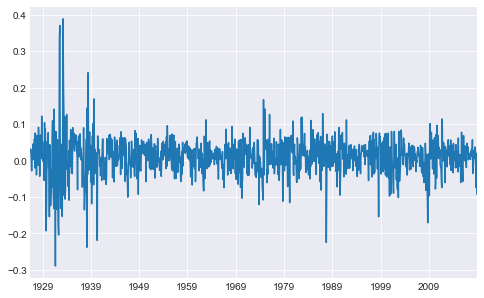

In [43]:
tot_mkt_rets = erk.get_total_market_index_returns()
tot_mkt_rets.plot(grid=True, figsize=(8,5))
plt.show()

The annualized volatility over the entire period is:

In [44]:
ann_vol_constant = erk.annualize_vol(tot_mkt_rets, periods_per_year=12)
ann_vol_constant

0.18360776591130698

However, let us using a rolling window and let us compute the timeseries of annualized volatilities:

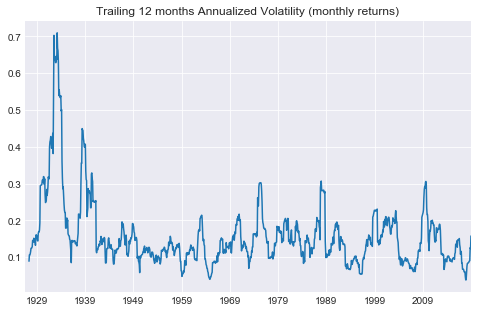

In [56]:
# pick yearly data (i.e., 12 monthly data)
window = 12
ann_vol_tv = tot_mkt_rets.rolling(window = 1*window).std() * np.sqrt(window)
ann_vol_tv.plot(grid=True, figsize=(8,5), title="Trailing 12 months Annualized Volatility (monthly returns)")
plt.show()

We see that the mean volatility of this timie-varying series is given by:

In [55]:
ann_vol_tv.mean()

0.15770732194601642

which is different from the "static" variance we have used over the entire period



#### Exponentially smoothing

#### Auto-Regression (ARCH) model 

#### Auto-Regression (GARCH) model 


We then try to address the stationarity risk, i.e., the fact that **risk parameters are not constant but move over time**. We start with basic rolling-window and exponentially-weighted moving average analysis and then move on to the estimation of covariance parameters with autoregressive conditional heteroskedasticity and state-dependent models.